# Oxford-iiit-pet (tensorflow)

> !pip install git+https://github.com/phylsix/dOD.git

In [1]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from dOD.tf_model.model import UNet
from dOD.tf_model.datasets import oxford_iiit
from dOD.tf_model.trainer import Trainer

H, W = oxford_iiit.IMAGE_SIZE

In [2]:
train_ds, test_ds = oxford_iiit.load_data()

In [3]:
modelMaker = UNet(input_shape=(H, W, oxford_iiit.CHANNELS),
                  kernel_shape=(3, 3), nlayer=2,
                  root_feature=64, depth=5, padding='same', activation='relu', norm_type='instancenorm',
                  drop_rate=0, num_classes=oxford_iiit.CLASSES)
modelMaker.build_net()
modelMaker.compile(learning_rate=1e-3,
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   metrics=['sparse_categorical_accuracy'])
modelMaker.describle()

-------- input shape: (None, 128, 128, 3)
    > layer 0 shape: (None, 128, 128, 64)
    > layer 2 shape: (None, 128, 128, 64)
    downstream layer 1 shape: (None, 128, 128, 64)
        > layer 0 shape: (None, 64, 64, 128)
        > layer 3 shape: (None, 64, 64, 128)
        downstream layer 2 shape: (None, 64, 64, 128)
            > layer 0 shape: (None, 32, 32, 256)
            > layer 3 shape: (None, 32, 32, 256)
            downstream layer 3 shape: (None, 32, 32, 256)
                > layer 0 shape: (None, 16, 16, 512)
                > layer 3 shape: (None, 16, 16, 512)
                downstream layer 4 shape: (None, 16, 16, 512)
                    > layer 0 shape: (None, 8, 8, 1024)
                    > layer 3 shape: (None, 8, 8, 1024)
                    bottom layer 5 shape: (None, 8, 8, 1024)
                > layer 0 shape: (None, 16, 16, 512)
                > layer 3 shape: (None, 16, 16, 512)
                upstream layer 4 shape: (None, 16, 16, 512)
            > la

In [4]:
T = Trainer(logbase=None)
history = T.fit(modelMaker.net, train_ds, validation_dataset=test_ds, epochs=25, batch_size=16)

Epoch 1/25
230/230 [==============================] - 115s 500ms/step - loss: 0.6245 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.5429 - val_sparse_categorical_accuracy: 0.7868
Epoch 2/25
230/230 [==============================] - 115s 499ms/step - loss: 0.4634 - sparse_categorical_accuracy: 0.8166 - val_loss: 0.4369 - val_sparse_categorical_accuracy: 0.8284
Epoch 3/25
230/230 [==============================] - 116s 504ms/step - loss: 0.4013 - sparse_categorical_accuracy: 0.8406 - val_loss: 0.3966 - val_sparse_categorical_accuracy: 0.8390
Epoch 4/25
230/230 [==============================] - 119s 517ms/step - loss: 0.3593 - sparse_categorical_accuracy: 0.8565 - val_loss: 0.3665 - val_sparse_categorical_accuracy: 0.8549
Epoch 5/25
230/230 [==============================] - 119s 515ms/step - loss: 0.3330 - sparse_categorical_accuracy: 0.8662 - val_loss: 0.3483 - val_sparse_categorical_accuracy: 0.8642
Epoch 6/25
230/230 [==============================] - 118s 513ms/step - loss: 0.

In [5]:
def show_history(history, EPOCHS=25):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))
  axes[0].plot(range(EPOCHS), train_loss, 'r--', label='training loss')
  axes[0].plot(range(EPOCHS), val_loss, 'bo', label='validation loss')
  axes[0].set_title('Training and validation loss')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].legend()

  axes[1].plot(range(EPOCHS), train_acc, 'r--', label='training accuracy')
  axes[1].plot(range(EPOCHS), val_acc, 'bo', label='validation accuracy')
  axes[1].set_title('Training and validation accuracy')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Accuracy')
  axes[1].legend()

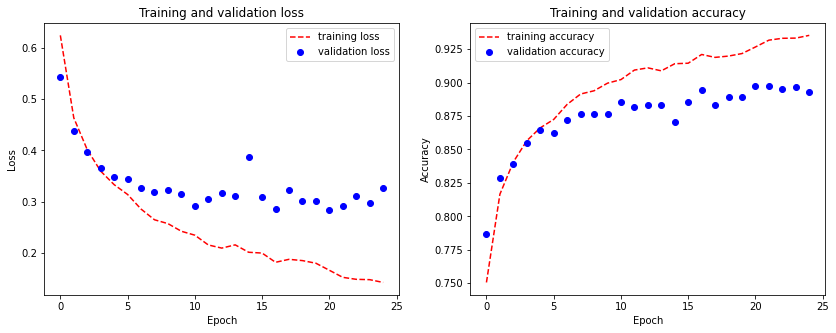

In [6]:
show_history(history, 25)

In [7]:
def show_result(train_ds, model, N=5):
    fig, axes = plt.subplots(3, N, sharex=True, sharey=True,
                            figsize=(N * 3, 9), gridspec_kw={'wspace': 0.01, 'hspace': 0.01})
    for i, (img, label) in enumerate(train_ds.shuffle(buffer_size=1000).take(N).batch(1)):
        prediction = model.predict(img)[0]
        axes[0][i].matshow(img[0])    
        axes[1][i].matshow(label[0, ..., 0], )
        axes[2][i].matshow(prediction.argmax(axis=-1), )
    for ax in axes:
        for x in ax:
            x.set_xticklabels([])
            x.set_yticklabels([])
    for i, x in enumerate(['image', 'label', 'prediction']):
        axes[i][0].set_ylabel(x)

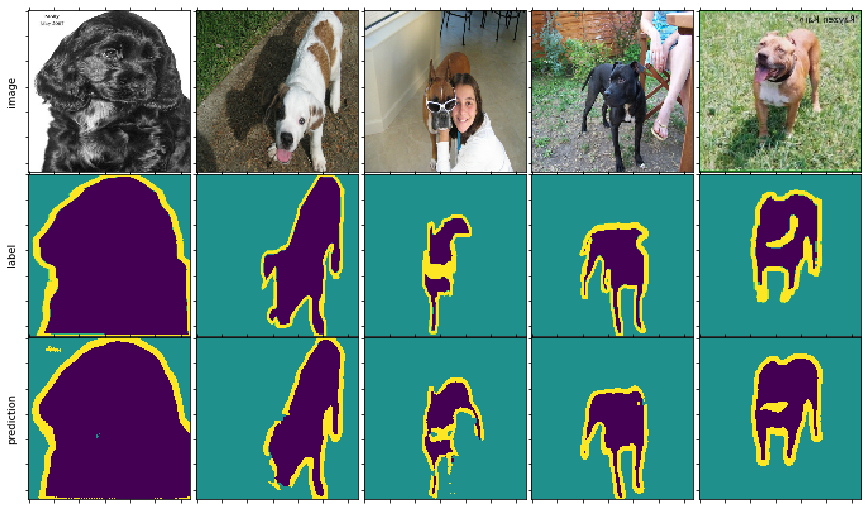

In [8]:
show_result(train_ds, modelMaker.net)